## Зеркальный спуск (20 баллов)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod
from collections import OrderedDict
from scipy.special import softmax

## Основная часть (10 баллов)

__Задача 1.__ Задача многорукого бандита (Multi-Armed Bandit) — это классическая модель обучения с подкреплением при частичной наблюдаемости, где агент последовательно выбирает одно из $K$ действий ("рук") и получает случайную награду, зависящую только от выбранного действия.

Формальная постановка:
- На каждом шаге $t=1, 2, \ldots, T$ агент выбирает действие $a_t \in \{1, \ldots, K \}$.
- Наблюдает награду $r \sim \mathcal{D}_{a_t}$, где $\mathcal{D}_i$ — неизвестное распределение награды для руки i.
- Цель — максимизировать суммарную ожидаемую награду или, что эквивалентно, минимизировать regret:

$$
R(T) = T \mu^* - \mathbb{E} \left[ \sum_{t = 1}^T r_t \right],~ \text{где}~ \mu^* = \max\limits_{i = \overline{1, K}} \mathbb{E}_{r \sim \mathcal{D}_i} [r].
$$

Основная сложность — дилемма исследования и эксплуатации: необходимо балансировать между использованием уже найденных хороших действий и исследованием других для уточнения их оценок.

Мы будем рассматривать `BernoulliBandit`. Действие приносит вознаграждение $r$ в размере 1 с фиксированной вероятностью $0 \leq \mu_i \leq 1$, которая неизвестна агенту. Цель агента — свести к минимуму regret:

$$
R(T) = T\mu^* - \sum_{t = 1}^T \mu_{a_t}, \text{где}~ \mu^* = \max\limits_{i = \overline{1, K}} \mu_i.
$$

In [2]:
class BernoulliBandit():
    def __init__(self, n_actions=5):
        self._probs = np.random.random(n_actions)

    @property
    def action_count(self):
        return len(self._probs)

    def pull(self, action):
        if np.any(np.random.random() > self._probs[action]):
            return 0.0
        return 1.0

    def optimal_reward(self):
        return np.max(self._probs)

    def action_value(self, action):
        return self._probs[action]

Класс `AbstractAgent` необходим, чтобы от него наследоваться.

In [3]:
class AbstractAgent(metaclass=ABCMeta):
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0

    def init_actions_agent(self, n_actions):
        pass

    @abstractmethod
    def get_action(self, action=None, reward=None):
        pass

    def update(self, action, reward):
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

    @property
    def name(self):
        return self.__class__.__name__

__а) (1 балл)__ В данном пункте необходимо реализовать одну из самых простых стратегий. В ней агент с вероятностью $\varepsilon$ выбирает случайную руку, а с вероятностью $1 - \varepsilon$ берет ту руку, у которой максимальная средняя награда на данный момент. Логика проста — если положить $\varepsilon = 0$, то это будет жадный алгоритм, в котором выберется лучшая рука на данный момент, но эта стратегия не всегда будет оптимальной. Для этого вводится случайность — с некоторой маленькой вероятностью выбирается какая-то рука, для того, чтобы была возможность вылезти из локального минимума.

**Псевдокод алгоритма**

---

_Инициализация:_

- Вероятность сэмплирования не жадной руки $\varepsilon \geq 0$

---

*$t$-ая итерация:*

Сэмплируем руку:
   - С вероятностью $\varepsilon$: $a_t \sim U \left(\overline{1, K}\right)$
   - С вероятностью $1 - \varepsilon$: $a_t = \arg \max\limits_{i = \overline{1, K}} \hat{\mu}_i$  

In [4]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon=0.01):
        self._epsilon = epsilon

    def get_action(self, action=None, reward=None):

        n_actions = len(self._successes)
        if np.random.random() < self._epsilon:
            action = np.random.randint(0, n_actions)
        else:
            means = self._successes / (self._successes + self._failures + 1e-12)
            action = np.argmax(means)
        return action

    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon)

Ниже представлена функция взаимодейтсвия агента с бандитом.

In [5]:
def get_regret(env, agents, n_steps=1000, n_trials=10):
    scores = OrderedDict({agent.name: [0.0 for step in range(n_steps)] for agent in agents})
    action = 0
    reward = 0

    for trial in range(n_trials):

        for a in agents:
            a.init_actions(env.action_count)
            a.init_actions_agent(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()

            for agent in agents:
                action = agent.get_action(action, reward)
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - env.action_value(action)

    for agent in agents:
        scores[agent.name] = np.cumsum(scores[agent.name]) / n_trials

    return scores

In [6]:
def plot_regret(agents, scores):
    for agent in agents:
        plt.plot(scores[agent.name])

    plt.legend([agent.name for agent in agents])

    plt.ylabel("Regret")
    plt.xlabel("Шаги")

    plt.show()

Постройте графики regret от номера шага для агентов с различным параметром `epsilon`.

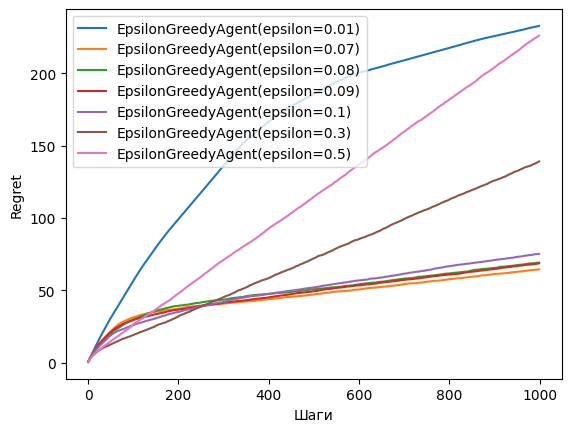

In [7]:
epsilons = [0.01, 0.07 , 0.08 ,0.09, 0.1, 0.3, 0.5]

agents = [EpsilonGreedyAgent(epsilon=e) for e in epsilons]

env = BernoulliBandit(n_actions=5)

scores = get_regret(env, agents, n_steps=1000, n_trials=20)

plot_regret(agents, scores)

Какой `epsilon` получился оптимальным и почему?

Оптимальное `epsilon` = 0.1, т.к. исследует достаточно, чтобы найти выгодную ручку, но и постоянно не теряет награду.

__б) (1 балл)__ Теперь рассмотрим чуть более сложную стратегию. Называется она Upper Confidence Bound (UCB) — из названия понятно, что нужно будет строить доверительные интервалы. Интуиция почти жадная — выбираем ту руку, для которой построенная оценка $\hat{\mu}_i$ имеет самую большую верхнюю оценку.

**Псевдокод алгоритма**

---

_Инициализация:_

- Инициализируем параметр $C \geq 1$ — он отвечает за уверенность

---

_$t$-ая итерация:_

- Сэмплируем руку:
$$
a_t = \arg \max_{i = \overline{1, K}} \left( \hat{\mu}_i + C \sqrt{\frac{\log t}{n_i + 10^{-8}}} \right)
$$

Почему такая странная формула для выбора руки? В [теории](https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf) указано, что при выборе $C = 1$ гарантируется, что рост регрета будет логарифмическим, что является оптимальной оценкой.

In [8]:
class UCBAgent(AbstractAgent):
    def __init__(self, C=1):
        self._C = C

    def get_action(self, action=None, reward=None):

        t = self._total_pulls + 1

        pulls_per_action = self._successes + self._failures
        if np.any(pulls_per_action == 0):
            return np.random.choice(np.where(pulls_per_action == 0)[0])

        means = self._successes / (pulls_per_action + 1e-12)
        ucb_values = means + self._C * np.sqrt(np.log(t) / (pulls_per_action + 1e-10))

        return np.argmax(ucb_values)

    @property
    def name(self):
        return self.__class__.__name__ + "(C={})".format(self._C)

Постройте графики regret от номера шага для `UCBAgent` агента с различным параметром `С`. Добавьте на график лучшего `EpsilonGreedyAgent` агента.

In [9]:
target_epsilon = 0.1

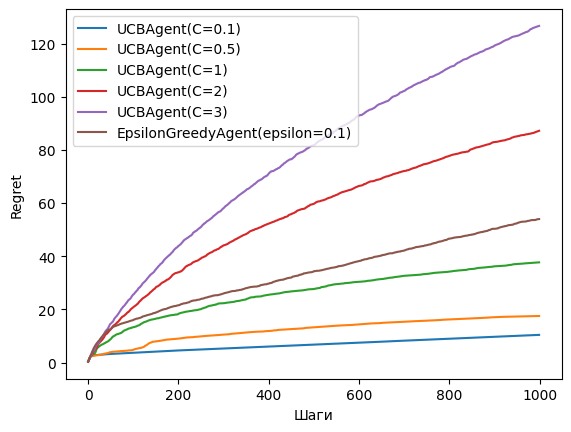

In [10]:
C_values = [0.1, 0.5, 1, 2, 3]

ucb_agents = [UCBAgent(C=c) for c in C_values]

eps_agent = EpsilonGreedyAgent(epsilon=target_epsilon)

ucb_agents.append(eps_agent)

env = BernoulliBandit(n_actions=5)

scores = get_regret(env, ucb_agents, n_steps=1000, n_trials=20)

plot_regret(ucb_agents, scores)

__в) (4 балла)__ Теперь поговорим про градиентные методы. При большом $K$ или при наличии корреляций между руками эффективны методы, основанные на онлайн-оптимизации на вероятностном симплексе:

$$
\Delta_{K - 1} = \left\{\pi \in \mathbb{R}^K \mid \pi \succeq 0,~ \boldsymbol{1}^\top \pi = 1 \right\}.
$$

Здесь $\pi_i$ интерпретируется как вероятность выбора $i$-ой руки. Политику $\pi$ можно параметризовать логитами $\theta \in \mathbb{R}^K$, а распределение над руками тогда

$$
\pi_i =  \frac{e^{\theta_i}}{\sum\limits_{a = 1}^K e^{\theta_{a}}}.
$$

Тогда можно рассмотреть минимизацию ожидаемого regret на шаге $t$:

$$
f_t(\theta) = 1 - \mathbb{E}_{a \sim \pi} [r_t(a)].
$$

Докажите, используя _log-derivative trick_, что градиент имеет вид

$$
\nabla_{\theta} f_t(\theta) = -\mathbb{E}_{a \sim \pi} \left[r_t(a) (e_a - \pi) \right].
$$

Доказательство:

Распишем матож по определению:
$$
\mathbb{E}_{a \sim \pi} [r_t(a)] = \sum_{a = 1}^K \pi_a(\theta) \cdot r_t(a).
$$

Найдем градиент по $\nabla$:
$$
\nabla_{\theta} (\sum_{a=1}^K \pi_a(\theta) r_t(a)) = \sum_{a=1}^K r_t(a) \nabla_{\theta} (\pi_a(\theta)).
$$

К $\pi_a(\theta)$ применим log-derivative trick:
$$
\nabla_{\theta} (\pi_a(\theta)) = \pi_a(\theta) \nabla_{\theta} (\log \pi_a(\theta))
$$

Тогда матож будет:
$$\sum_{a=1}^K r_t(a) \nabla_{\theta} \pi_a(\theta) = \sum_{a=1}^K \pi_a(\theta) ( r_t(a) \nabla_{\theta} \log \pi_a(\theta) )  = \mathbb{E}_{a \sim \pi} \left[ r_t(a) \nabla_{\theta} \log \pi_a(\theta) \right].$$

Остается найти $\nabla_{\theta} \log \pi_a(\theta)$:
$$
\frac{\partial \log \pi_a(\theta)}{\partial \theta_j} = \delta_{aj} - \frac{e^{\theta_j}}{\sum_{k=1}^K e^{\theta_k}} = \delta_{aj} - \pi_j(\theta)
$$
где $\delta_{aj}$ - символ Кронекера

Тогда $\nabla_{\theta} \log \pi_a(\theta) = e_a - \pi$

И тогда $\nabla_{\theta} f_t(\theta) = -\mathbb{E}_{a \sim \pi} \left[r_t(a) (e_a - \pi) \right]$

Сделаем градиентный спуск, где обновление происходит только по наблюдаемой руке:

$$
\theta_{a_t}^{t + 1} = \theta_{a_t}^t + \gamma_t \cdot r_t \cdot (1 - \pi_{a_t}).
$$

In [11]:
class GDAgent(AbstractAgent):
    def __init__(self, gamma=0.1, n_actions=5):
        self._gamma = gamma
        self._tetas = np.zeros(n_actions)

    def init_actions_agent(self, n_actions):
        self._tetas = np.zeros(n_actions)

    def get_action(self, action, reward):
        if action is not None and reward is not None:
            exp_t = np.exp(self._tetas - np.max(self._tetas))
            pi = exp_t / np.sum(exp_t)

            self._tetas[action] += self._gamma * reward * (1 - pi[action])

        exp_t = np.exp(self._tetas - np.max(self._tetas))
        pi = exp_t / np.sum(exp_t)

        return np.random.choice(len(self._tetas), p=pi)

    @property
    def name(self):
        return self.__class__.__name__ + "(gamma={})".format(self._gamma)

Постройте графики regret от номера шага для `GDAgent` агента с различным параметром `gamma`. Добавьте на график лучших `EpsilonGreedyAgent` и `UCBAgent` агентов.

In [12]:
target_C = 0.5
eps_agent = EpsilonGreedyAgent(epsilon=target_epsilon)
ucb_agent = UCBAgent(C=target_C)

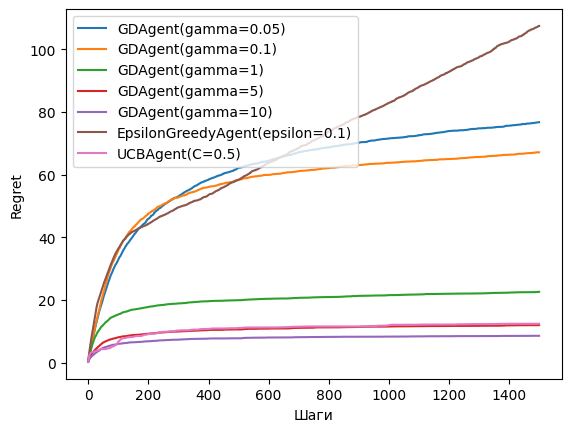

In [13]:
gammas = [0.05, 0.1, 1, 5, 10]

gd_agents = [GDAgent(gamma=g, n_actions=5) for g in gammas]


gd_agents.append(eps_agent)
gd_agents.append(ucb_agent)

env = BernoulliBandit(n_actions=5)

scores = get_regret(env, gd_agents, n_steps=1500, n_trials=20)

plot_regret(gd_agents, scores)

__г) (4 балла)__ Так как мы работаем с вероятностными распределениями, то для зеркального спуска логично взять в качестве дивергенции Брэгмана расстояние Кульбака—Лейблера:

$$
KL(p \parallel q) = \sum_{i = 1}^K p_i \log \frac{p_i}{q_i}.
$$

Как и в случае градиентной политики, зеркальный спуск в контексте многорукого бандита также оперирует распределением вероятностей над действиями. Однако он оптимизирует не логиты $\theta$, а работает в пространстве вероятностей $\pi \in \Delta_{K - 1}$. Также, как в прошлом задании, рассмотрим минимизацию ожидаемого regret на шаге $t$:

$$
f_t(\pi) = 1 - \mathbb{E}_{a \sim \pi} [r_t(a)].
$$

Алгоритм зеркального спуска на шаге $t$ решает следующую задачу:

$$
\pi^{t + 1} = \arg \min_{\pi \in \Delta_{K - 1}} \left\{ \langle \gamma_t g^t, \pi \rangle + KL(\pi \parallel \pi^t) \right\}.
$$

Покажите, что для $KL$ дивергенции решение этой задачи имеет вид:

$$
\pi_i^{t + 1} = \frac{\pi_i^t \cdot \exp(-\gamma_t g_i^t)}{\sum\limits_{j = 1}^K \pi_j^t \cdot \exp(-\gamma_t g_j^t)}.
$$

Агент наблюдает только $r_t$ для выбранного действия $a_t$, а не весь вектор $g^t$. Чтобы получить несмещённую оценку градиента, используется _importance weighting_:
$$
\hat{g}_i^t = -\frac{\mathbb{I}\{i = a_t\} \cdot r_t}{\pi_i^t}.
$$

Подставляя эту оценку в правило обновления, получаем:

$$
\pi_i^{t + 1} = \frac{\pi_i^t \cdot \exp\left(\gamma_t \frac{\mathbb{I}\{i = a_t\} \cdot r_t}{\pi_i^t} \right)}{\sum\limits_{j = 1}^K \pi_j^t \cdot \exp\left(\gamma_t \frac{\mathbb{I}\{j = a_t\} \cdot r_t}{\pi_i^t} \right)}.
$$

In [14]:
class MDAgent(AbstractAgent):
    def __init__(self, gamma=0.1, n_actions=5):
        self._gamma = gamma
        self._tetas = np.zeros(n_actions)

    def init_actions_agent(self, n_actions):
        self._tetas = np.random.normal(0, 0.1, n_actions)


    def get_action(self, action=None, reward=None):
        if action is not None:
            probs = softmax(self._tetas)
            pi_action = probs[action]

            if pi_action > 1e-12:
                update_val = self._gamma * reward / pi_action
                self._tetas[action] += update_val

        probs = softmax(self._tetas)
        return np.random.choice(len(probs), p=probs)

    def _softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / np.sum(exp_x)

    @property
    def name(self):
        return self.__class__.__name__ + "(gamma={})".format(self._gamma)

Постройте графики regret от номера шага для `MDAgent` агента с различным параметром `gamma`. Добавьте на график лучших `EpsilonGreedyAgent`, `UCBAgent`, `GDAgent` агентов.

In [15]:
target_gamma = 10
gd_agent = GDAgent(gamma=target_gamma, n_actions=5)

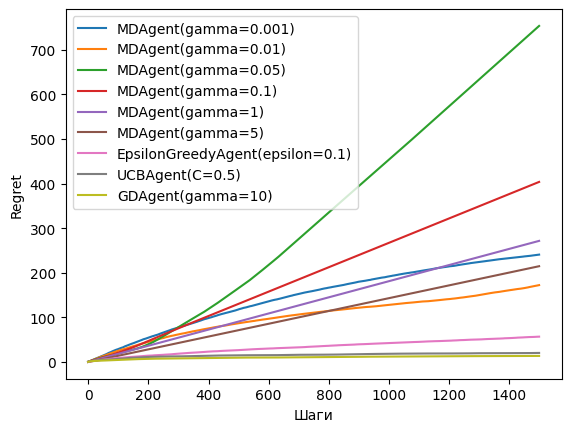

In [16]:
gammas = [0.001, 0.01, 0.05, 0.1, 1, 5]

mgd_agents = [MDAgent(gamma=g, n_actions=5) for g in gammas]

mgd_agents.append(eps_agent)
mgd_agents.append(ucb_agent)
mgd_agents.append(gd_agent)

env = BernoulliBandit(n_actions=5)

scores = get_regret(env, mgd_agents, n_steps=1500, n_trials=20)

plot_regret(mgd_agents, scores)